# In this notebook a LogisticRegression model for each type of layer is trained and evaluated.

This is useful to understand which layers are more suitable for the hallucination detection task.

In [ ]:
import json
import os
import numpy as np
import torch
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# ==================================================================
# REPRODUCIBILITY SETTINGS
# ==================================================================
SEED = 42

def set_seed(seed=SEED):
    """Set all seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

def get_balanced_indices(y, seed=SEED):
    """
    Calcola gli indici per bilanciare il dataset tramite undersampling.
    Questa funzione è DETERMINISTICA dato lo stesso seed e le stesse label.
    
    Args:
        y: numpy array delle label
        seed: seed per la riproducibilità
    
    Returns:
        balanced_indices: numpy array degli indici selezionati (ordinati)
    """
    rng = np.random.RandomState(seed)
    
    unique_classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    
    selected_indices = []
    
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        
        if len(cls_indices) > min_count:
            sampled = rng.choice(cls_indices, size=min_count, replace=False)
            selected_indices.extend(sampled)
        else:
            selected_indices.extend(cls_indices)
    
    return np.sort(np.array(selected_indices))

In [ ]:

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
CACHE_DIR_NAME = "activation_cache"
HF_DEFAULT_HOME = os.environ.get("HF_HOME", "~\\.cache\\huggingface\\hub")


In [ ]:
# Funzione per statistiche compatibile con la nuova struttura
# La nuova struttura ha le attivazioni separate in cartelle hallucinated/ e not_hallucinated/
# invece di un file hallucination_labels.json

def stats_per_json(model_name, dataset_name):
    """
    Versione originale per la vecchia struttura con hallucination_labels.json
    """
    file_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name,"generations","hallucination_labels.json")
    with open(file_path, 'r') as file:
        data = json.load(file)
    total = len(data)
    hallucinations = sum(1 for item in data if item['is_hallucination'])
    percent_hallucinations = (hallucinations / total) * 100 if total > 0 else 0
    allucinated_items = [item['instance_id'] for item in data if item['is_hallucination']]
    return {
        'total': total,
        'hallucinations': hallucinations,
        'percent_hallucinations': percent_hallucinations,
        'hallucinated_items': allucinated_items,
        'model_name': model_name,
        'dataset_name': dataset_name
    }

def stats_from_new_structure(model_name, dataset_name):
    """
    Nuova funzione per la struttura con cartelle hallucinated/ e not_hallucinated/
    """
    base_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, "activation_attn")
    hallucinated_path = os.path.join(base_path, "hallucinated")
    not_hallucinated_path = os.path.join(base_path, "not_hallucinated")
    
    # Carica gli instance_ids da un layer (layer0) per contare i campioni
    hall_ids_path = os.path.join(hallucinated_path, "layer0_instance_ids.json")
    not_hall_ids_path = os.path.join(not_hallucinated_path, "layer0_instance_ids.json")
    
    with open(hall_ids_path, 'r') as f:
        hallucinated_ids = json.load(f)
    with open(not_hall_ids_path, 'r') as f:
        not_hallucinated_ids = json.load(f)
    
    total = len(hallucinated_ids) + len(not_hallucinated_ids)
    hallucinations = len(hallucinated_ids)
    percent_hallucinations = (hallucinations / total) * 100 if total > 0 else 0
    
    return {
        'total': total,
        'hallucinations': hallucinations,
        'not_hallucinations': len(not_hallucinated_ids),
        'percent_hallucinations': percent_hallucinations,
        'hallucinated_ids': hallucinated_ids,
        'not_hallucinated_ids': not_hallucinated_ids,
        'model_name': model_name,
        'dataset_name': dataset_name
    }

def detect_structure_type(model_name, dataset_name):
    """
    Rileva automaticamente se la struttura è vecchia o nuova.
    Ritorna 'new' se esistono le cartelle hallucinated/not_hallucinated,
    altrimenti 'old'.
    """
    base_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, "activation_attn")
    hallucinated_path = os.path.join(base_path, "hallucinated")
    if os.path.isdir(hallucinated_path):
        return 'new'
    return 'old'

def get_stats(model_name, dataset_name):
    """
    Funzione wrapper che rileva automaticamente la struttura e chiama la funzione appropriata.
    """
    structure = detect_structure_type(model_name, dataset_name)
    if structure == 'new':
        return stats_from_new_structure(model_name, dataset_name)
    else:
        return stats_per_json(model_name, dataset_name)

In [ ]:
# Elenca i modelli e dataset disponibili
available_models = os.listdir(os.path.join(PROJECT_ROOT, CACHE_DIR_NAME))
print("Modelli disponibili:", available_models)

# Scegli modello e dataset
MODEL_NAME = "gemma-2-9b-it"  # Cambia secondo necessità
DATASET_NAME = "entailment_bank"      # Cambia secondo necessità

# Verifica la struttura
structure_type = detect_structure_type(MODEL_NAME, DATASET_NAME)
print(f"Struttura dati rilevata per {MODEL_NAME}/{DATASET_NAME}: {structure_type}")

# Ottieni statistiche
stats = get_stats(MODEL_NAME, DATASET_NAME)
print(f"\nStatistiche per {MODEL_NAME}:")
print(f"  Totale campioni: {stats['total']}")
print(f"  Allucinazioni: {stats['hallucinations']} ({stats['percent_hallucinations']:.2f}%)")

# Se vuoi confrontare più modelli
if "Llama-3.1-8B-Instruct" in available_models:
    gemma_stats = get_stats("Llama-3.1-8B-Instruct", DATASET_NAME)
    print(f"\nStatistiche per Llama-3.1-8B-Instruct")
    print(f"  Totale campioni: {gemma_stats['total']}")
    print(f"  Allucinazioni: {gemma_stats['hallucinations']} ({gemma_stats['percent_hallucinations']:.2f}%)")

Modelli disponibili: ['test_3', 'gemma-2-9b-it', 'test_1', 'Llama-3.1-8B-Instruct', 'test_2']
Struttura dati rilevata per gemma-2-9b-it/belief_bank_facts: new

Statistiche per gemma-2-9b-it:
  Totale campioni: 27416
  Allucinazioni: 802 (2.93%)

Statistiche per Llama-3.1-8B-Instruct
  Totale campioni: 27416
  Allucinazioni: 1799 (6.56%)


In [ ]:
def layers_in_model(model, dataset=None):
    """
    Conta il numero di layer nel modello.
    Supporta sia la vecchia che la nuova struttura.
    """
    file_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model)
    
    # Se non viene specificato il dataset, prendi il primo disponibile
    if dataset is None:
        subdirs = [d for d in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, d))]
        if not subdirs:
            raise ValueError(f"No subdirectories found in {file_path}")
        dataset = subdirs[0]
    
    layer_dir = os.path.join(file_path, dataset, "activation_attn")
    
    # Controlla se è la nuova struttura (con cartelle hallucinated/not_hallucinated)
    hallucinated_path = os.path.join(layer_dir, "hallucinated")
    if os.path.isdir(hallucinated_path):
        # Nuova struttura: conta i file layer*_activations.pt nella cartella hallucinated
        layer_files = [f for f in os.listdir(hallucinated_path) if f.endswith('_activations.pt')]
        return len(layer_files)
    else:
        # Vecchia struttura: conta i file layer*_activations.pt direttamente
        layer_files = [f for f in os.listdir(layer_dir) if f.endswith('_activations.pt')]
        return len(layer_files)

In [ ]:
def load_activations_and_labels(model_name, dataset_name, layer, layer_type):
    """
    Carica le attivazioni e le label per un dato layer e tipo.
    Supporta sia la vecchia che la nuova struttura dati.
    
    IMPORTANTE: Per la nuova struttura, le attivazioni vengono ordinate
    in base agli instance_ids per garantire la corretta corrispondenza
    tra campioni di diversi layer/tipi.
    
    Returns:
        X: numpy array delle attivazioni (n_samples, hidden_dim) - ordinate per instance_id
        y: numpy array delle label (n_samples,) - 1=hallucination, 0=correct
        instance_ids: numpy array degli instance_ids (n_samples,) - ordinati
    """
    structure = detect_structure_type(model_name, dataset_name)
    base_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, f"activation_{layer_type}")
    
    if structure == 'new':
        # Nuova struttura: carica da hallucinated/ e not_hallucinated/
        hall_act_path = os.path.join(base_path, "hallucinated", f"layer{layer}_activations.pt")
        hall_ids_path = os.path.join(base_path, "hallucinated", f"layer{layer}_instance_ids.json")
        not_hall_act_path = os.path.join(base_path, "not_hallucinated", f"layer{layer}_activations.pt")
        not_hall_ids_path = os.path.join(base_path, "not_hallucinated", f"layer{layer}_instance_ids.json")
        
        # Carica attivazioni
        hall_activations = torch.load(hall_act_path)
        not_hall_activations = torch.load(not_hall_act_path)
        
        # Carica instance_ids
        with open(hall_ids_path, 'r') as f:
            hall_ids = json.load(f)
        with open(not_hall_ids_path, 'r') as f:
            not_hall_ids = json.load(f)
        
        # Converti in numpy
        if isinstance(hall_activations, torch.Tensor):
            hall_activations = hall_activations.cpu().numpy().astype(np.float32)
        if isinstance(not_hall_activations, torch.Tensor):
            not_hall_activations = not_hall_activations.cpu().numpy().astype(np.float32)
        
        # Concatena attivazioni, label e ids
        X_concat = np.vstack([hall_activations, not_hall_activations])
        y_concat = np.concatenate([
            np.ones(hall_activations.shape[0], dtype=int),
            np.zeros(not_hall_activations.shape[0], dtype=int)
        ])
        ids_concat = np.array(hall_ids + not_hall_ids)
        
        # Ordina tutto in base agli instance_ids
        sort_indices = np.argsort(ids_concat)
        X = X_concat[sort_indices]
        y = y_concat[sort_indices]
        instance_ids = ids_concat[sort_indices]
        
        return X, y, instance_ids
    
    else:
        # Vecchia struttura: carica tutto insieme e usa hallucination_labels.json
        file_path = os.path.join(base_path, f"layer{layer}_activations.pt")
        activations = torch.load(file_path)
        
        if isinstance(activations, torch.Tensor):
            X = activations.cpu().numpy().astype(np.float32)
        else:
            X = activations.astype(np.float32)
        
        # Carica le label dal JSON
        labels_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, 
                                   "generations", "hallucination_labels.json")
        with open(labels_path, 'r') as f:
            labels_data = json.load(f)
        
        y = np.array([item['is_hallucination'] for item in labels_data], dtype=int)
        instance_ids = np.arange(len(y))  # IDs sequenziali per la vecchia struttura
        
        return X, y, instance_ids

In [ ]:
# Verifica che le attivazioni siano ordinate correttamente per instance_id
def verify_ordering(model_name, dataset_name, layer=0, layer_type="attn"):
    """
    Verifica che le attivazioni siano ordinate per instance_id.
    """
    X, y, instance_ids = load_activations_and_labels(model_name, dataset_name, layer, layer_type)
    
    print(f"=== Verifica ordinamento per {model_name}/{dataset_name} ===")
    print(f"Layer: {layer}, Tipo: {layer_type}")
    print(f"Numero di campioni: {len(instance_ids)}")
    print(f"\nPrimi 20 instance_ids: {instance_ids[:20].tolist()}")
    print(f"Ultime 20 instance_ids: {instance_ids[-20:].tolist()}")
    
    # Verifica se sono ordinati
    is_sorted = np.all(instance_ids[:-1] <= instance_ids[1:])
    print(f"\nGli instance_ids sono ordinati in ordine crescente: {is_sorted}")
    
    # Verifica corrispondenza label
    print(f"\nPrime 20 label (y): {y[:20].tolist()}")
    print(f"Ultime 20 label (y): {y[-20:].tolist()}")
    
    # Statistiche sulle label
    print(f"\nDistribuzione label:")
    print(f"  Hallucination (y=1): {np.sum(y == 1)}")
    print(f"  Not hallucination (y=0): {np.sum(y == 0)}")
    
    return X, y, instance_ids

# Esegui verifica
X_test, y_test, ids_test = verify_ordering(MODEL_NAME, DATASET_NAME, layer=0, layer_type="attn")

# Verifica anche che diversi layer/tipi abbiano lo stesso ordinamento
print("\n" + "="*60)
print("Verifica consistenza tra diversi layer/tipi...")
print("="*60)

_, y_attn, ids_attn = load_activations_and_labels(MODEL_NAME, DATASET_NAME, 0, "attn")
_, y_mlp, ids_mlp = load_activations_and_labels(MODEL_NAME, DATASET_NAME, 0, "mlp")
_, y_hidden, ids_hidden = load_activations_and_labels(MODEL_NAME, DATASET_NAME, 0, "hidden")

print(f"IDs attn == IDs mlp: {np.array_equal(ids_attn, ids_mlp)}")
print(f"IDs attn == IDs hidden: {np.array_equal(ids_attn, ids_hidden)}")
print(f"Labels attn == Labels mlp: {np.array_equal(y_attn, y_mlp)}")
print(f"Labels attn == Labels hidden: {np.array_equal(y_attn, y_hidden)}")

=== Verifica ordinamento per Qwen2.5-7B/belief_bank ===
Layer: 0, Tipo: attn
Numero di campioni: 27416

Primi 20 instance_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Ultime 20 instance_ids: [27396, 27397, 27398, 27399, 27400, 27401, 27402, 27403, 27404, 27405, 27406, 27407, 27408, 27409, 27410, 27411, 27412, 27413, 27414, 27415]

Gli instance_ids sono ordinati in ordine crescente: True

Prime 20 label (y): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ultime 20 label (y): [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]

Distribuzione label:
  Hallucination (y=1): 3565
  Not hallucination (y=0): 23851

Verifica consistenza tra diversi layer/tipi...
IDs attn == IDs mlp: True
IDs attn == IDs hidden: True
Labels attn == Labels mlp: True
Labels attn == Labels hidden: True


In [ ]:
# Configurazione
MODELS_TO_ANALYZE = [MODEL_NAME]  # Aggiungi altri modelli se necessario
if "Llama-3.1-8B-Instruct" in available_models:
    MODELS_TO_ANALYZE.append("Llama-3.1-8B-Instruct")

DATASET = DATASET_NAME

# Inizializza i risultati
results = {model: {"attn": {}, "mlp": {}, "hidden": {}} for model in MODELS_TO_ANALYZE}

# Per ogni modello
for model in MODELS_TO_ANALYZE:
    print(f"\n{'='*60}")
    print(f"Elaborazione modello: {model}")
    print(f"{'='*60}")
    
    num_layers = layers_in_model(model, DATASET)
    print(f"Numero di layer rilevati: {num_layers}")
    
    # ============================================
    # CALCOLA INDICI UNA SOLA VOLTA
    # ============================================
    X_sample, y_sample, _ = load_activations_and_labels(model, DATASET, 0, "attn")
    n_samples = X_sample.shape[0]
    print(f"Numero di campioni originali: {n_samples}")
    print(f"Distribuzione originale: {np.bincount(y_sample)}")
    
    del X_sample  # Libera subito
    
    # Undersampling globale
    balanced_indices = get_balanced_indices(y_sample, seed=SEED)
    y_balanced = y_sample[balanced_indices]
    print(f"Dopo undersampling: {len(balanced_indices)} campioni")
    print(f"Distribuzione bilanciata: {np.bincount(y_balanced)}")
    
    # Split stratificato sui dati bilanciati
    train_rel_idx, test_rel_idx = train_test_split(
        np.arange(len(balanced_indices)),
        test_size=0.3,
        random_state=SEED,
        stratify=y_balanced
    )
    
    # Converti in indici assoluti
    train_indices = balanced_indices[train_rel_idx]
    test_indices = balanced_indices[test_rel_idx]
    
    print(f"Train: {len(train_indices)}, Test: {len(test_indices)}")
    print(f"Train dist: {np.bincount(y_sample[train_indices])}, Test dist: {np.bincount(y_sample[test_indices])}")
    
    del y_sample, y_balanced
    gc.collect()
    
    # ============================================
    # LOOP SUI LAYER
    # ============================================
    for layer in range(num_layers):
        for layer_type in ["attn", "mlp", "hidden"]:
            # Carica attivazioni e label
            X_layer, y, _ = load_activations_and_labels(model, DATASET, layer, layer_type)
            
            # Applica gli indici PRE-CALCOLATI
            X_train = X_layer[train_indices]
            y_train = y[train_indices]
            X_test = X_layer[test_indices]
            y_test = y[test_indices]
            
            del X_layer, y  # Libera memoria subito
            
            # Normalizzazione
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Addestramento (lbfgs è più veloce per dataset piccoli)
            clf = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs', n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]
            
            # Metriche
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auroc = roc_auc_score(y_test, y_proba)
            
            # Salva i risultati
            results[model][layer_type][layer] = (accuracy, f1, auroc)
            
            print(f"  Layer {layer} {layer_type}: Acc={accuracy:.4f}, F1={f1:.4f}, AUROC={auroc:.4f}")
            
            del X_train, X_test, y_train, y_test, scaler, clf
            gc.collect()

print("\n" + "="*60)
print("Training completato!")
print("="*60)


Elaborazione modello: Qwen2.5-7B
Numero di layer rilevati: 28
Numero di campioni originali: 27416
Distribuzione originale: [23851  3565]
Dopo undersampling: 7130 campioni
Distribuzione bilanciata: [3565 3565]
Train: 4991, Test: 2139
Train dist: [2495 2496], Test dist: [1070 1069]
  Layer 0 attn: Acc=0.9677, F1=0.9676, AUROC=0.9872
  Layer 0 mlp: Acc=0.9738, F1=0.9737, AUROC=0.9885
  Layer 0 hidden: Acc=0.9691, F1=0.9691, AUROC=0.9866
  Layer 1 attn: Acc=0.9617, F1=0.9617, AUROC=0.9846
  Layer 1 mlp: Acc=0.9631, F1=0.9630, AUROC=0.9847
  Layer 1 hidden: Acc=0.9673, F1=0.9673, AUROC=0.9890
  Layer 2 attn: Acc=0.9724, F1=0.9725, AUROC=0.9900
  Layer 2 mlp: Acc=0.9645, F1=0.9643, AUROC=0.9892
  Layer 2 hidden: Acc=0.9682, F1=0.9681, AUROC=0.9911
  Layer 3 attn: Acc=0.9691, F1=0.9690, AUROC=0.9908
  Layer 3 mlp: Acc=0.9710, F1=0.9710, AUROC=0.9910
  Layer 3 hidden: Acc=0.9701, F1=0.9700, AUROC=0.9904
  Layer 4 attn: Acc=0.9696, F1=0.9694, AUROC=0.9904
  Layer 4 mlp: Acc=0.9738, F1=0.9737, 

In [ ]:
# Funzione per ordinare tutti i layer per accuracy e salvare su JSON
def sort_and_save_all_results(results, output_file="sorted_results.json"):
    """
    Ordina tutti i layer per accuracy in ordine decrescente e salva su JSON.
    
    Args:
        results: dizionario completo dei risultati nel formato:
                 {model_name: {layer_type: {layer_num: (accuracy, f1, auroc)}}}
        output_file: path del file JSON di output
    
    Returns:
        dizionario con tutti i risultati ordinati
    """
    sorted_results = {}
    
    for model_name, layer_types in results.items():
        sorted_results[model_name] = {}
        
        for layer_type, layer_data in layer_types.items():
            # Ordina i layer per accuracy decrescente
            sorted_layers = sorted(
                [(layer, acc, f1, auroc) for layer, (acc, f1, auroc) in layer_data.items()],
                key=lambda x: x[1],  # ordina per accuracy
                reverse=True  # ordine decrescente
            )
            
            # Salva in formato lista ordinata
            sorted_results[model_name][layer_type] = [
                {
                    "layer": layer,
                    "accuracy": round(acc, 4),
                    "f1_score": round(f1, 4),
                    "auroc": round(auroc, 4)
                }
                for layer, acc, f1, auroc in sorted_layers
            ]
    
    # Salva su JSON
    with open(output_file, 'w') as f:
        json.dump(sorted_results, f, indent=4)
    print(f"Tutti i risultati ordinati salvati in {output_file}")
    
    return sorted_results

# Salva tutti i risultati ordinati
sorted_all = sort_and_save_all_results(results, "all_layers_sorted.json")

Tutti i risultati ordinati salvati in all_layers_sorted.json


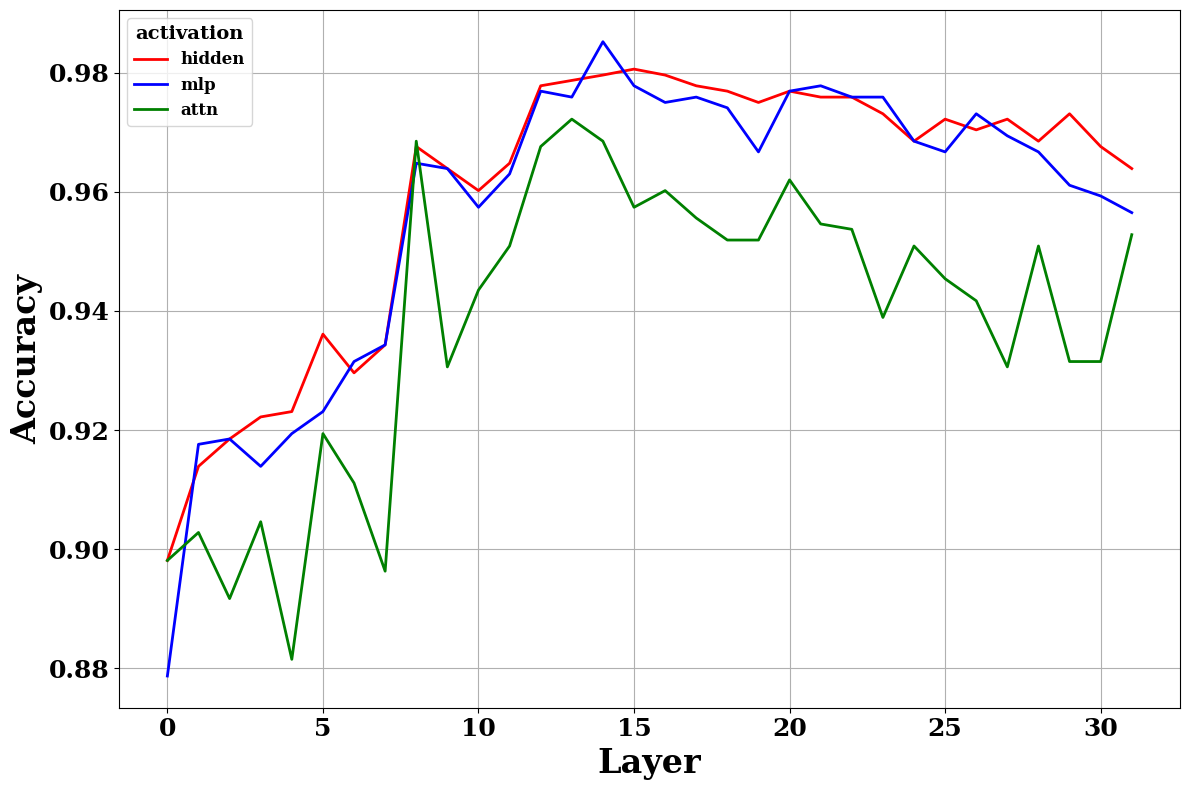

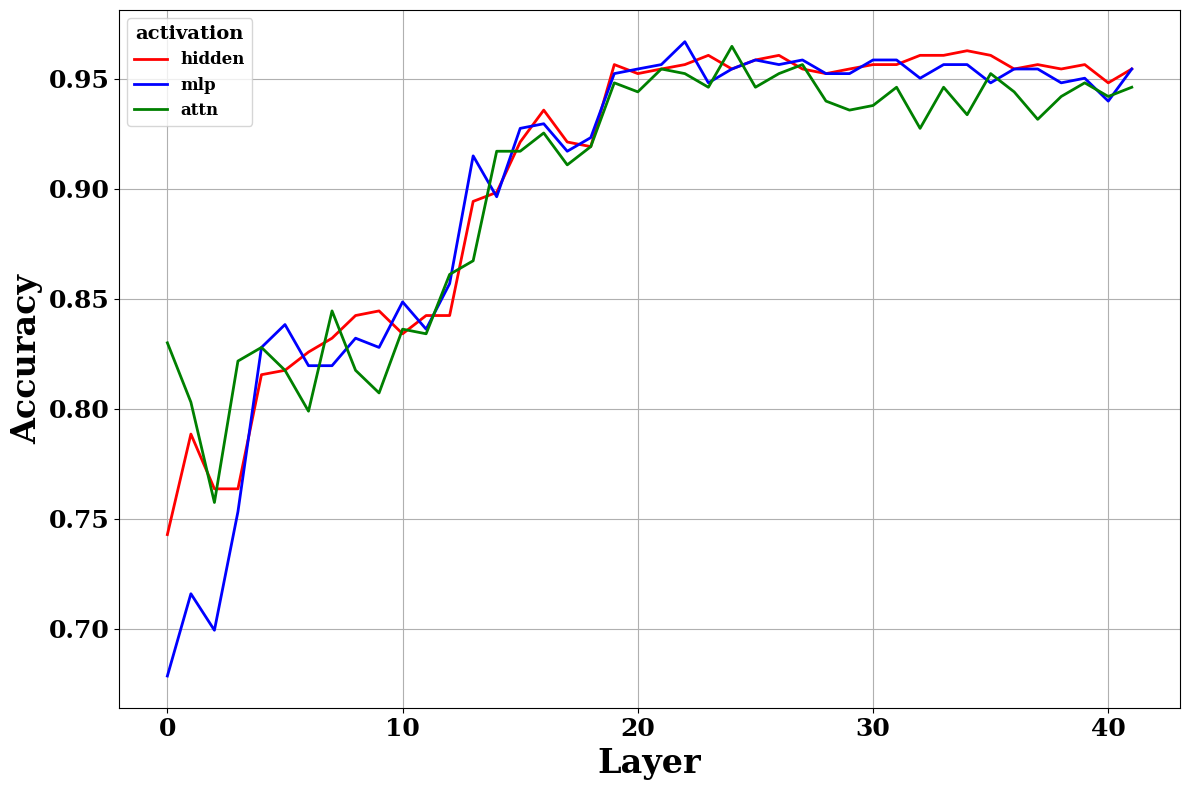

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_from_json(json_data, model_name=None, dataset="Dataset"):
    """
    Genera un grafico dell'accuracy per layer.
    
    Args:
        json_data (dict): Il dizionario caricato dal file JSON.
        model_name (str): Il nome del modello da plottare.
                          Se None, prende il primo modello trovato nel JSON.
        dataset (str): Nome del dataset per il titolo del file.
    """
    
    # 1. Selezione del modello
    if model_name is None:
        model_name = list(json_data.keys())[0]
    
    if model_name not in json_data:
        print(f"Errore: Modello '{model_name}' non trovato nel JSON.")
        return

    data = json_data[model_name]

    # 2. Configurazione dello Stile
    plt.rcParams.update({
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 12,
        "legend.title_fontsize": 14,
        "lines.linewidth": 2
    })

    # Creazione della figura
    fig, ax = plt.subplots(figsize=(12, 8))

    # Mappatura colori
    styles = {
        "hidden": {"color": "red", "label": "hidden"},
        "mlp":    {"color": "blue", "label": "mlp"},
        "attn":   {"color": "green", "label": "attn"}
    }

    # 3. Estrazione e Ordinamento dei dati
    for key in ["hidden", "mlp", "attn"]:
        if key in data:
            points = data[key]
            sorted_points = sorted(points, key=lambda x: x['layer'])
            layers = [item['layer'] for item in sorted_points]
            accuracies = [item['accuracy'] for item in sorted_points]
            ax.plot(layers, accuracies, 
                    color=styles[key]["color"], 
                    label=styles[key]["label"])

    # 4. Rifinitura Grafica
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    ax.grid(True, linestyle='-', alpha=1.0)
    
    legend = ax.legend(title="activation", loc="upper left", frameon=True)
    plt.setp(legend.get_title(), fontweight='bold')

    plt.tight_layout()
    
    # Crea la cartella img se non esiste
    os.makedirs("img", exist_ok=True)
    plt.savefig(f"img/{model_name}_{dataset}_activations.pdf")
    #plt.show()

# Carica e visualizza i risultati
content = json.load(open('all_layers_sorted_GEMMA_LLAMA_BBF.json', 'r'))
DATASET = DATASET_NAME
for model_name in content.keys():
    plot_accuracy_from_json(content, model_name, DATASET)